In [253]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.decomposition as skd
import sklearn.preprocessing as skp

In [254]:
def normalize(data):#normalize the data
    return skp.normalize(data)

In [255]:
def pca(data, n): #perform PCA on data to reduce dimensionality (change the n_components / features to see how it affects the results)
    data = normalize(data)
    pca = skd.PCA(n_components=n)
    pca.fit(data)
    return pca.transform(data)

In [256]:
data = np.loadtxt("inputs.txt")
labels = np.loadtxt("labels.txt")

In [257]:
m, n = data.shape #m is the number of data-points /samples, n is the number of features
n =  50 #training with 50 features out of 2352

In [258]:
#code to shuffle 2 arrays, and keep corresponding elements
randomize = np.arange(len(labels)) 
np.random.shuffle(randomize) #creates a randomized sequence to be used as an index for the two arrays to shuffle them (https://www.delftstack.com/howto/numpy/python-numpy-shuffle-two-arrays/)

data = data[randomize]
labels = labels[randomize]

data = pca(data, n)

#This is to avoid dimension issues with np.dot 
#Also...I took small samples of the date to test the ann
training_data = data[:1800].T
Y_training = labels[:1800]
X_training = training_data[0:n]

validation_data = data[1600:1900].T #note, includes start index, excludes end index
Y_validation = labels[1600:1900]
X_validation = validation_data[0:n]

testing_data = data[1900:].T
Y_testing = labels[1900:]
X_testing = testing_data[0:n]

print(data.shape)

(2000, 50)


In [259]:
def sigmoid(Z):
    return 1/(1 + np.exp(-Z))

In [260]:
def sigmoid_prime(Z):
    return Z * (1 - Z)

In [261]:
def softmax(Z):
    return np.exp(Z)/np.sum(np.exp(Z), axis=0)

In [262]:
def rand_params(): #generate a random set of weights and biases for the neural network between -1 and 1
    w1= np.random.rand(20, n) - 1 # n is the number of features
    b1 = np.random.rand(20, 1) - 1
    w2 = np.random.rand(20, 20) - 1
    b2 = np.random.rand(20, 1) - 1
    w3 = np.random.rand(10, 20) - 1
    b3 = np.random.rand(10, 1) - 1
    return w1, b1, w2, b2, w3, b3

In [263]:
def forward_prop(X, w1, b1, w2, b2, w3, b3): #forward propagation
    Z1 = np.dot(w1, X) + b1
    A1 = sigmoid(Z1)
    Z2 = np.dot(w2, A1) + b2
    A2 = sigmoid(Z2)
    Z3 = np.dot(w3, A2) + b3
    A3 = softmax(Z3)
    return A1, A2, A3

In [264]:
def one_hot_encode(labels): #encode labels as one-hot vectors
    labels = labels.astype(int)
    encoded_labels = np.zeros((labels.size, 10))
    for i in range(labels.size):
        encoded_labels[i][labels[i]] = 1
    return encoded_labels.T

In [265]:
print(one_hot_encode(Y_training))
print(Y_training)

[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 1.]]
[1. 8. 4. ... 3. 9. 9.]


In [266]:
def regularize(w1, w2, w3): #regularization (lambda = 0.99)
    w1 = w1 * 0.99
    w2 = w2 * 0.99
    w3 = w3 * 0.99

In [267]:
#Parameters:
#w1, b1, w2, b2, w3, b3: weights and biases
#X: training data
#Y: training labels
#A1, A2, A3: activation functions

#Returns:
#dw1, db1, dw2, db2, dw3, db3: deltas for weights and biases
def backprop(X, Y, A1, A2, A3, w1, b1, w2, b2, w3, b3): #backpropagation
    Y = one_hot_encode(Y)
    dZ3 = A3 - Y
    dW3 = np.dot(dZ3, A2.T)
    db3 = np.sum(dZ3, axis=1, keepdims=True)
    dA2 = np.dot(w3.T, dZ3)
    dZ2 = dA2 * sigmoid_prime(A2)
    dW2 = np.dot(dZ2, A1.T)
    db2 = np.sum(dZ2, axis=1, keepdims=True)
    dA1 = np.dot(w2.T, dZ2)
    dZ1 = dA1 * sigmoid_prime(A1)
    dW1 = np.dot(dZ1, X.T)
    db1 = np.sum(dZ1, axis=1, keepdims=True)
    return dW1, db1, dW2, db2, dW3, db3

In [268]:
#Parameters:
#dW1, db1, dW2, db2, dW3, db3: deltas for weights and biases

#Returns:   
#w1, b1, w2, b2, w3, b3: updated weights and biases
def update_params(w1, b1, w2, b2, w3, b3, dW1, db1, dW2, db2, dW3, db3, learning_rate): #update parameters
    w1 = w1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    w2 = w2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    w3 = w3 - learning_rate * dW3
    b3 = b3 - learning_rate * db3
    regularize(w1, w2, w3) #regularize weights
    return w1, b1, w2, b2, w3, b3

In [269]:
def get_predictions(A3): 
    return np.argmax(A3,0)

def get_accuracy(predictions, Y):
    accuracy = np.sum(predictions == Y) / Y.size
    return accuracy * 100

In [270]:
# https://towardsdatascience.com/simple-guide-to-hyperparameter-tuning-in-neural-networks-3fe03dad8594
def gradient_descent(X, Y, epochs, learning_rate): #gradient descent -> learn weights and biases
    w1, b1, w2, b2, w3, b3 = rand_params()
    accuracy = []
    for i in range(epochs):
        A1, A2, A3 = forward_prop(X, w1, b1, w2, b2, w3, b3)
        dW1, db1, dW2, db2, dW3, db3 = backprop(X, Y, A1, A2, A3, w1, b1, w2, b2, w3, b3)
        w1, b1, w2, b2, w3, b3 = update_params(w1, b1, w2, b2, w3, b3, dW1, db1, dW2, db2, dW3, db3, learning_rate)
        accuracy.append(get_accuracy(get_predictions(A3), Y))
        
    return w1, b1, w2, b2, w3, b3, accuracy

In [271]:
epochs = 3000
alpha = 0.01
#learnt set of weights and biases (this is basically what we are submitting)
w1, b1, w2, b2, w3, b3, accuracy = gradient_descent(X_training, Y_training, epochs, alpha)

training_accuracy = get_accuracy(get_predictions(forward_prop(X_training, w1, b1, w2, b2, w3, b3)[2]), Y_training)
print("Epochs: ",epochs,"|","Training Accuracy: ", training_accuracy,"%")

Epochs:  3000 | Training Accuracy:  99.3888888888889 %


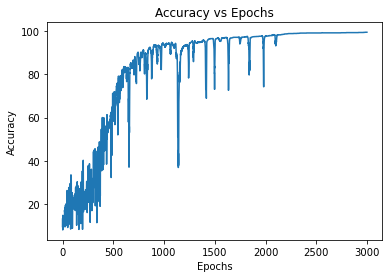

In [272]:
itr  = np.arange(0,epochs)
plt.plot(itr, accuracy)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs")
plt.show()

In [273]:
validation_accuracy = get_accuracy(get_predictions(forward_prop(X_validation, w1, b1, w2, b2, w3, b3)[2]), Y_validation)
print("Epochs: ",epochs,"|","Validation Accuracy: ", validation_accuracy,"%")

Epochs:  3000 | Validation Accuracy:  95.66666666666667 %


In [274]:
testing_accuracy = get_accuracy(get_predictions(forward_prop(testing_data, w1, b1, w2, b2, w3, b3)[2]), Y_testing)
print("Epochs: ",epochs,"|","Testing Accuracy: ", testing_accuracy,"%")

Epochs:  3000 | Testing Accuracy:  89.0 %


In [275]:
print(testing_data.shape)

(50, 100)


In [277]:
np.savetxt("w1.txt", w1)
np.savetxt("b1.txt", b1)
np.savetxt("w2.txt", w2)
np.savetxt("b2.txt", b2)
np.savetxt("w3.txt", w3)
np.savetxt("b3.txt", b3)